# RNN for 3D keypoint generation

## Build network with Keras

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import time
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mdn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from data_utils import *

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import keypoint sequences

In [2]:
look_back = 10

#load data, you can filter with: dancers = ["maria", "raymond", ...] and tags = ["impro", ...]
X, y = get_training_data(look_back = look_back)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle= True, random_state=42)

print("data shape:")
print("X_train: ", np.shape(X_train))
print("y_train: ", np.shape(y_train))
print("X_test: ", np.shape(X_test))
print("y_test: ", np.shape(y_test))

data shape:
X_train:  (1955835, 10, 51)
y_train:  (1955835, 51)
X_test:  (102939, 10, 51)
y_test:  (102939, 51)


### build model

In [10]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(look_back, 51),  return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(32))
model.add(mdn.MDN(51, 3))
model.compile(loss=mdn.get_mixture_loss_func(51,3), optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 32)            10752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
mdn (MDN)                    (None, 309)               10197     
Total params: 38,645
Trainable params: 38,645
Non-trainable params: 0
_________________________________________________________________


### Train model

Epoch 1/100
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
15280/15280 [==============================] - 119s 8ms/step - loss: -46.3357 - val_loss: -92.1843

Epoch 00001: val_loss improved from inf to -92.18433, saving model to models/lstm_mdn2-E01-VL-92.18.h5
Epoch 2/100
15280/15280 [==============================] - 114s 7ms/step - loss: -94.8495 - val_loss: -106.3392

Epoch 00002: val_loss improved from -92.18433 to -106.33917, saving model to models/lstm_mdn2-E02-VL-106.34.h5
Epoch 3/100
15280/15280 [==============================] - 114s 7ms/step - loss: -108.3162 - val_loss: -115.8184

Epoch 00003: val_loss improved from -106.33917 to -115.81843, saving model to models/lstm_mdn2-E03-VL-115.82.h5
Epoch 4/100
15280/15280 [==============================] - 114s 7ms/step - loss: -115.2802 - val_loss: -114.1235

Epoch 00004: val_loss did not improve from -115.81843
Epoch 5/100
15280/15280 [==============================] - 114s 7ms/step - loss:

15280/15280 [==============================] - 114s 7ms/step - loss: -170.7361 - val_loss: -169.8977

Epoch 00085: val_loss did not improve from -172.30994
Epoch 86/100
15280/15280 [==============================] - 114s 7ms/step - loss: -171.2127 - val_loss: -167.9251

Epoch 00086: val_loss did not improve from -172.30994
Epoch 87/100
15280/15280 [==============================] - 114s 7ms/step - loss: -171.2180 - val_loss: -168.8228

Epoch 00087: val_loss did not improve from -172.30994
Epoch 88/100
15280/15280 [==============================] - 114s 7ms/step - loss: -171.3748 - val_loss: -165.3074

Epoch 00088: val_loss did not improve from -172.30994
Epoch 89/100
15280/15280 [==============================] - 114s 7ms/step - loss: -171.5649 - val_loss: -169.9235

Epoch 00089: val_loss did not improve from -172.30994
Epoch 90/100
15280/15280 [==============================] - 114s 7ms/step - loss: -171.4214 - val_loss: -173.3821

Epoch 00090: val_loss improved from -172.30994 to -17

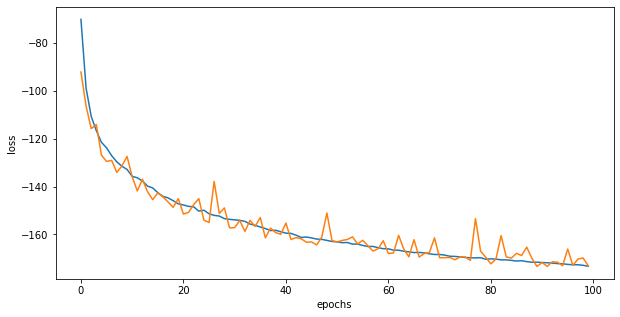

In [12]:
# Parameters
BATCH_SIZE = 128
limit = int(np.floor(len(X_train)/BATCH_SIZE))*BATCH_SIZE
EPOCHS = 100
VAL_SPLIT = 0.05


# Define callbacks
filepath="models/lstm_mdn2-E{epoch:02d}-VL{val_loss:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks = [keras.callbacks.TerminateOnNaN(), checkpoint, early_stopping]

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=VAL_SPLIT)

# Save the Model
model.save('models/lstm-mdn.h5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### load model

In [3]:
model = tf.keras.models.load_model('models/lstm-mdn.h5',custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(51,3)}) 

### Generate sequence(s)

In [4]:
longer_performance = generate_performance(model,X_test[1500], steps_limit=1000)

#save to file in json format so that it can be used by 
save_seq_to_json(longer_performance, "test_performance.json", path_base_dir=os.path.abspath("./"))